/var/folders/8v/2ttqzjvx4mq_6d8v7nq5kvxm0000gn/T/ipykernel_27572/1581569599.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['STAT_ARRIV'] = pd.to_datetime(df['STAT_ARRIV'], errors='coerce')
/var/folders/8v/2ttqzjvx4mq_6d8v7nq5kvxm0000gn/T/ipykernel_27572/1581569599.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sample_date'] = df_filtered['STAT_ARRIV'].dt.date


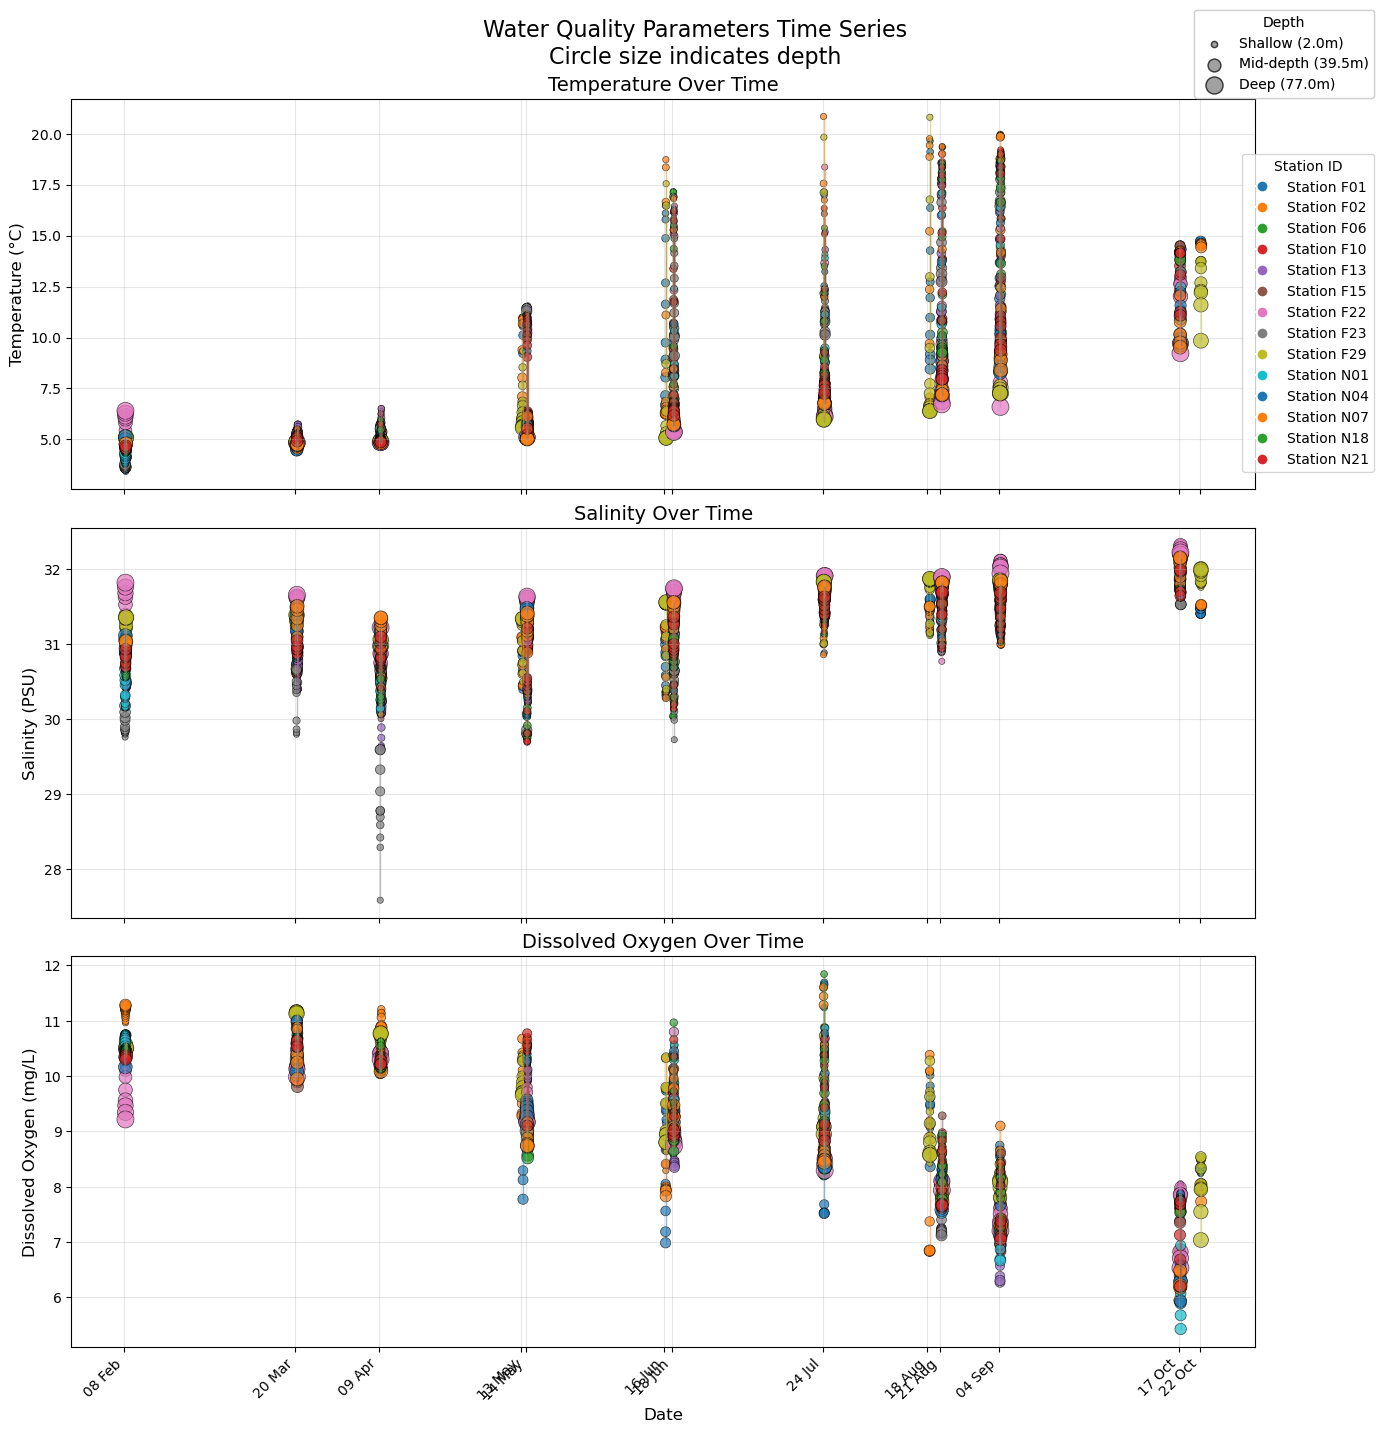

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from datetime import datetime

def plot_water_quality_time_series(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Convert STAT_ARRIV to datetime (coerce errors just in case)
    df['STAT_ARRIV'] = pd.to_datetime(df['STAT_ARRIV'], errors='coerce')
    
    # Filter out rows with missing data for our parameters
    df_filtered = df.dropna(subset=['STAT_ARRIV', 'DEPTH', 'TEMP', 'SAL', 'DISS_OXYGEN'])
    
    # Extract the date (no time) from STAT_ARRIV for grouping
    df_filtered['sample_date'] = df_filtered['STAT_ARRIV'].dt.date
    
    # Define a function to resample depths within each (date, station) group
    def resample_by_depth(group, num_samples=10):
        """
        Given a group's data, pick up to num_samples points spaced along DEPTH.
        """
        if len(group) <= num_samples:
            return group
        return group.sort_values('DEPTH').iloc[::max(1, len(group)//num_samples)]
    
    # Resample each group
    groups = []
    for (date, station), group in df_filtered.groupby(['sample_date', 'STAT_ID']):
        groups.append(resample_by_depth(group))
        
    df_resampled = pd.concat(groups)
    
    # Create a figure with 3 subplots (vertical)
    fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    # Depth-to-size mapping
    min_depth = df_resampled['DEPTH'].min()
    max_depth = df_resampled['DEPTH'].max()
    
    def depth_to_size(depth):
        # Normalize depth to a size range 20 -> 150
        normalized = (depth - min_depth) / (max_depth - min_depth)
        return 20 + normalized * 130
    
    df_resampled['point_size'] = df_resampled['DEPTH'].apply(depth_to_size)
    
    # Map each station ID to a color
    station_colors = plt.cm.tab10.colors
    station_ids = df_resampled['STAT_ID'].unique()
    color_map = {
        station: station_colors[i % len(station_colors)]
        for i, station in enumerate(station_ids)
    }
    
    # Plot data by date and station
    for date, group in df_resampled.groupby('sample_date'):
        for station, station_group in group.groupby('STAT_ID'):
            # Sort so lines connect in correct order of depth
            station_group = station_group.sort_values('DEPTH')
            
            # Same x-value for each point in this group (the station's arrival time)
            plot_time = station_group['STAT_ARRIV'].iloc[0]
            
            # Pick color for this station
            station_color = color_map[station]
            
            # 1) Temperature
            axes[0].scatter(
                [plot_time]*len(station_group),
                station_group['TEMP'],
                s=station_group['point_size'],
                color=station_color,
                alpha=0.7,
                edgecolor='k',
                linewidth=0.5
            )
            axes[0].plot(
                [plot_time]*len(station_group),
                station_group['TEMP'],
                '-',
                color=station_color,
                linewidth=1,
                alpha=0.5
            )
            
            # 2) Salinity
            axes[1].scatter(
                [plot_time]*len(station_group),
                station_group['SAL'],
                s=station_group['point_size'],
                color=station_color,
                alpha=0.7,
                edgecolor='k',
                linewidth=0.5
            )
            axes[1].plot(
                [plot_time]*len(station_group),
                station_group['SAL'],
                '-',
                color=station_color,
                linewidth=1,
                alpha=0.5
            )
            
            # 3) Dissolved Oxygen
            axes[2].scatter(
                [plot_time]*len(station_group),
                station_group['DISS_OXYGEN'],
                s=station_group['point_size'],
                color=station_color,
                alpha=0.7,
                edgecolor='k',
                linewidth=0.5
            )
            axes[2].plot(
                [plot_time]*len(station_group),
                station_group['DISS_OXYGEN'],
                '-',
                color=station_color,
                linewidth=1,
                alpha=0.5
            )
    
    # Titles, labels, and grids
    axes[0].set_title('Temperature Over Time', fontsize=14)
    axes[0].set_ylabel('Temperature (°C)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Salinity Over Time', fontsize=14)
    axes[1].set_ylabel('Salinity (PSU)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_title('Dissolved Oxygen Over Time', fontsize=14)
    axes[2].set_ylabel('Dissolved Oxygen (mg/L)', fontsize=12)
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    # ----------------------------
    # Manual tick setup (EXACT DATES)
    # ----------------------------
    unique_dates = sorted(df_resampled['sample_date'].unique())
    # Convert date objects to datetime objects at midnight
    date_positions = [datetime.combine(d, datetime.min.time()) for d in unique_dates]
    
    # Set the ticks to these positions
    axes[2].set_xticks(date_positions)
    # Format each tick label as "DD MMM", e.g., "07 Mar"
    axes[2].set_xticklabels([d.strftime("%d %b") for d in date_positions], rotation=45, ha='right')
    
    # Create custom legend for depth (show shallow, mid, deep)
    depth_categories = [
        (min_depth, "Shallow"),
        ((min_depth + max_depth) / 2, "Mid-depth"),
        (max_depth, "Deep")
    ]
    depth_handles = [
        plt.scatter([], [], s=depth_to_size(d), color='gray', alpha=0.7, edgecolor='k', 
                    label=f"{label} ({d:.1f}m)")
        for d, label in depth_categories
    ]
    
    # Create custom legend for stations
    station_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[s], 
               markersize=8, label=f"Station {s}")
        for s in station_ids
    ]
    
    # Place legends
    depth_legend = fig.legend(
        handles=depth_handles,
        loc='upper right',
        title="Depth",
        bbox_to_anchor=(0.99, 0.99)
    )
    station_legend = fig.legend(
        handles=station_handles,
        loc='upper right',
        title="Station ID",
        bbox_to_anchor=(0.99, 0.90)
    )
    fig.add_artist(depth_legend)  # ensures both legends are displayed
    
    # Common figure title
    fig.suptitle(
        'Water Quality Parameters Time Series\nCircle size indicates depth',
        fontsize=16
    )
    
    # Adjust layout so x-labels don't get cut off
    plt.tight_layout()
    # Add extra bottom margin for the rotated date labels
    plt.subplots_adjust(bottom=0.15, right=0.9, top=0.93)
    
    # Save the figure to a file and show
    plt.savefig('water_quality_size_depth.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================
# Run the function
# ============================
if __name__ == "__main__":
    file_path = "data/MWRA-DOWNCAST-2024.csv"
    plot_water_quality_time_series(file_path)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import os

# File path to the CSV
file_path = 'data/MWRA-DOWNCAST-2024.csv'

def plot_daily_depth_profiles(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Convert STAT_ARRIV to datetime
    df['STAT_ARRIV'] = pd.to_datetime(df['STAT_ARRIV'])
    
    # Filter out rows with missing data for our parameters of interest
    df_filtered = df.dropna(subset=['STAT_ARRIV', 'DEPTH', 'TEMP', 'SAL', 'DISS_OXYGEN'])
    
    # Extract date part from STAT_ARRIV for grouping
    df_filtered['sample_date'] = df_filtered['STAT_ARRIV'].dt.date
    
    # Create output directory for the daily plots
    output_dir = 'daily_profiles'
    os.makedirs(output_dir, exist_ok=True)
    
    # Get a list of unique dates
    unique_dates = sorted(df_filtered['sample_date'].unique())
    
    # Colors for different stations
    station_colors = plt.cm.tab10.colors
    station_ids = df_filtered['STAT_ID'].unique()
    color_map = {station: station_colors[i % len(station_colors)] 
                for i, station in enumerate(station_ids)}
    
    # Loop through each date and create a set of plots
    for date in unique_dates:
        # Filter data for the current date
        day_data = df_filtered[df_filtered['sample_date'] == date]
        
        # Skip if no data for this day
        if len(day_data) == 0:
            continue
            
        # Create a figure with 3 subplots (1 row, 3 columns)
        fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
        
        # For each station on this date, plot the depth profiles
        for station, station_data in day_data.groupby('STAT_ID'):
            # Sort by depth
            station_data = station_data.sort_values('DEPTH')
            
            # Get the station color
            station_color = color_map[station]
            
            # Extract timestamp for the title (use the first entry)
            timestamp = station_data['STAT_ARRIV'].iloc[0]
            
            # Temperature vs Depth
            axes[0].plot(station_data['TEMP'], station_data['DEPTH'], 'o-', 
                        color=station_color, linewidth=2, markersize=5,
                        label=f'Station {station}')
            
            # Salinity vs Depth
            axes[1].plot(station_data['SAL'], station_data['DEPTH'], 'o-', 
                        color=station_color, linewidth=2, markersize=5)
            
            # Dissolved Oxygen vs Depth
            axes[2].plot(station_data['DISS_OXYGEN'], station_data['DEPTH'], 'o-', 
                        color=station_color, linewidth=2, markersize=5)
            
        # Format date for title
        formatted_date = date.strftime("%d %B %Y")
        
        # Set titles and labels
        fig.suptitle(f'Water Quality Depth Profiles - {formatted_date}', fontsize=16)
        
        axes[0].set_title('Temperature vs Depth', fontsize=14)
        axes[0].set_xlabel('Temperature (°C)', fontsize=12)
        axes[0].set_ylabel('Depth (m)', fontsize=12)
        axes[0].grid(True)
        
        axes[1].set_title('Salinity vs Depth', fontsize=14)
        axes[1].set_xlabel('Salinity (PSU)', fontsize=12)
        axes[1].grid(True)
        
        axes[2].set_title('Dissolved Oxygen vs Depth', fontsize=14)
        axes[2].set_xlabel('Dissolved Oxygen (mg/L)', fontsize=12)
        axes[2].grid(True)
        
        # Invert the y-axis to show depth increasing downward
        for ax in axes:
            ax.invert_yaxis()
        
        # Add a legend only to the first plot
        axes[0].legend(loc='upper right')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save the figure for this date
        date_str = date.strftime("%Y-%m-%d")
        plt.savefig(f'{output_dir}/depth_profiles_{date_str}.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
    
    # Create a summary figure with thumbnails of all daily plots (optional)
    create_summary_figure(unique_dates, output_dir)
    
    print(f"Daily profiles have been saved to the '{output_dir}' directory.")

def create_summary_figure(unique_dates, output_dir):
    """Create a summary figure with thumbnails of all daily plots"""
    # Determine grid size based on number of dates
    n_dates = len(unique_dates)
    n_cols = min(4, n_dates)
    n_rows = (n_dates + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axes = np.array(axes).reshape(-1)  # Flatten axes array for easy indexing
    
    for i, date in enumerate(unique_dates):
        if i < len(axes):
            date_str = date.strftime("%Y-%m-%d")
            img_path = f'{output_dir}/depth_profiles_{date_str}.png'
            
            # Only add to summary if the file exists
            if os.path.exists(img_path):
                img = plt.imread(img_path)
                axes[i].imshow(img)
                axes[i].set_title(date.strftime("%d %b"), fontsize=10)
                axes[i].axis('off')
    
    # Hide unused axes
    for i in range(len(unique_dates), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_profiles_summary.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

# Run the function with the file path
plot_daily_depth_profiles(file_path)

/var/folders/8v/2ttqzjvx4mq_6d8v7nq5kvxm0000gn/T/ipykernel_27084/3413464292.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['STAT_ARRIV'] = pd.to_datetime(df['STAT_ARRIV'])
/var/folders/8v/2ttqzjvx4mq_6d8v7nq5kvxm0000gn/T/ipykernel_27084/3413464292.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sample_date'] = df_filtered['STAT_ARRIV'].dt.date


Daily profiles have been saved to the 'daily_profiles' directory.
